# Generalization of gradient and newton method + case with constraints
## Introduction

In the previous chapters of gradient and newton descent, we were able to have acess directly to the derivatives of the functions studied, sometimes it's hard to get this acess, and instead of having the exact derivative function, we compute an approximation of the derivative at point using the definition

In this chapter we will see how to compute any type of gradient or hessian matrix of a function, then we will see one or two methods used when we want operate a minimization using gradient or newton descent under constraints, and in the real life we want to optimize functions under constraints

As a bonus we will compare our implementations with scipy implementations

## Plan of this lecon 
### 1 - General gradient and hessian matrix
Starting from the mathematical definition, we give an implementation to the gradient and hessian matrix
### 2- Generalisation of Newton method  (Lagrangien-Method included)
Here we will see how we can use newton method for optimization problem using the lagrangien method
### 3- Practical real life problem
Here we are going to use the theory in a real case faced in the industry

## 1 - General gradient and hessian matrix
### 1.1 - Gradient
#### 1.1.1 - Gradient definition 
We take the same definition in the previous chapter of the gradient 

$\overrightarrow{grad}f =  \begin{pmatrix} 
 \frac{\partial f}{\partial x_1} \\
 .\\
 \frac{\partial f}{\partial x_i}\\
.\\
\frac{\partial f}{\partial x_n}
\end{pmatrix}$

Where $ \frac{\partial f}{\partial x_i}$ is defined as :  $ \frac{\partial f}{\partial x_i} =\lim\limits_{dx_i\to 0} \frac{f((x_1,...,x_i + dx_i,...,x_n)) - f((x_1,...,x_i,...,x_n))}{dx_i}$ 

We take a function $f$, and for each $ith$ compenent, we do a tiny perturbation and get $ \frac{\partial f}{\partial x_i}$ then reconstruct all of the $\overrightarrow{grad}f$

#### 1.1.2 - Gradient implementation 


In [1]:
import numpy as np
def gradient_f(f,x):
    #f the function
    assert (x.shape[0] >= x.shape[1]), "the vector should be a column vector"
    x = x.astype(np.float64)
    N = x.shape[0]
   
    gradient = []
    f0 = f(x)
    x1 = np.array(x)
    # the peturbation is relative to x that why we multiply by norm(x)
    eps = abs(np.linalg.norm(x) *  np.finfo(np.float32).eps )
    for i in range(N):
        xx0 =  np.float(x[i])
       # eps =  np.finfo(np.float32).eps 
        x[i] = x[i] + eps
        f1 = f(x)
        # Here we use the definition of the partial derivative
        gradient.append(np.asscalar(f1 - f0)/eps)
        x[i] = xx0
    return np.array(gradient).reshape(x.shape)

#### 1.1.3 - Comparaison with temperature example
Our function temperature from the preivous gradient chapter is defined as $T = \frac{x^2}{2} + y^2$
and it's gradient is :
$\overrightarrow{grad}T(x, y) = \begin{pmatrix} 
\frac{\partial T(x, y)}{\partial x}  \\
\frac{\partial T(x, y)}{\partial y}  
\end{pmatrix}=\begin{pmatrix} 
x  \\
2y  
\end{pmatrix}
$

Now we will be comparing our implementation of the general gradient to the real gradient then to scipy implementation, one of the best python library for linear algebra

In [2]:
#defining Temprature function
def T(x):
    return ((x[0])**2)/2 + ((x[1])**2) 
#defining Grad of T
def gradT(x):
    return np.array([x[0] , 2 * x[1]]).reshape(x.shape)

In [3]:
# we take a random point in space
x = np.random.rand(2,1).reshape(2,1) * 100

print("point choosen : \n",x,"\n")
print("val of real gradient: \n",gradT(x))
print("val of our implemented gradient: \n",gradient_f(T,x))

point choosen : 
 [[63.45752486]
 [79.92252735]] 

val of real gradient: 
 [[ 63.45752486]
 [159.8450547 ]]
val of our implemented gradient: 
 [[ 63.45753087]
 [159.84506689]]


#### 1.1.4 - Comparaison with scipy


In [4]:
#Scipy is the python library for linear algebra, that contain a lot off implementations 
import scipy
from scipy import optimize
eps = np.sqrt(np.finfo(np.float).eps)
xx = x.reshape(2,)
optimize.approx_fprime(xx, T, [np.sqrt(xx[0]) * eps, np.sqrt(xx[1]) * eps])


array([ 63.45751433, 159.84504657])

#### 1.1.5 Comments
As excpected, our implementation is close to scipy implementation and close to the real gradient evaluation

### 1.2 - Hessian
#### 1.1.2 - Hessian definition
The hessian matrix of a function $f$ is defined as 
$\textbf{H}_{f(x)} =  \begin{pmatrix} 
\frac{\partial^2 f(x)}{\partial x_{1}^2} &..& \frac{\partial^2 f(x)}{\partial x_1  \partial x_n} \\
\frac{\partial^2 f(x)}{\partial x_n  \partial x_1} &..& \frac{\partial^2 f(x)}{\partial x_{n}^2}
\end{pmatrix}$   

The hessian matrix some how can be seen as applying the gradient operator 2 times, a 1st time we obtain a vector, a second time on each componenent of the first vector obtained, then we will use this idea to do the implementation

In [5]:
def hessian (f, x):
    N = x.shape[0]
    x = x.astype(np.float64)
    hessian = np.zeros((N,N)) 
    gd_0 = gradient_f(f,x)
    eps = abs(np.linalg.norm(gd_0) * np.finfo(np.float32).eps )
    for i in range(N):
        xx0 = np.float(x[i])
        x[i] = xx0 + eps
        gd_1 =  gradient_f(f, x)
        hessian[:,i] = ((gd_1 - gd_0)/eps).reshape(x.shape[0])
        x[i] =xx0
    return hessian

In [6]:
hessian(T, x)

array([[ 0.99902877,  0.00894606],
       [-0.0039872 ,  2.00416247]])

Knowing that the hessian matrix computed in Newton descent chapter section 3.1 is $\begin{pmatrix} 
1 & 0\\
0 &  2 
\end{pmatrix}$ we had by this method an approximation of it, without any need to know the real differentiation of the function 

### 2 - Generalisation of Newton method  (Lagrangien-Method included)
Now that we have seen implementations of gradient and hessian, we will see first how we plug them in newton algorithm then we will see the most important thing of this chapter : $ \textbf{the case when we have constraints and we want to do an optimization} $


#### 2.1 - General Newton descent (without constraints) 

As a reminder Newton sequence is $ x_{n + 1} = x_n+ -  {f^{''}(x)}^{-1} f^{'}(x)$ and the temperature equation is $T(x,y)  = \frac{x^2}{2} + y^2$

If we run the newton optimization, we should find the minumum is achieved for $x = 0$ and $y = 0$

In [7]:
# Implementation
def newton(func, x0, tol = 1e-4):
    #eps = abs(np.linalg.norm(x0) *   np.finfo(np.float32).eps) 
    x1 = np.ones(x0.shape[0]).reshape(x0.shape) + x0
   # import pdb; pdb.set_trace()
    while(np.linalg.norm(x1 - x0) > tol):
        x0 = x1
        grad = gradient_f(func, x0)
        x1 = x0 - np.linalg.inv(hessian(func, x0)) @ (grad)
    return x1

In [8]:
x = newton(T, x)
print("val of x :", x[0])
print("val of y :", x[1])

val of x : [2.9646285e-09]
val of y : [-2.03979133e-10]


As expected $x \approx 0$ and $y \approx 0$ we have good reasons of thinking that our algorithm behaves as expected, let's move to the case with constraints

#### 2.2 - Case with constraints
##### 2.2.1 - Intro

This is one of the most important section in the optimization part, it's a little bit heavy to explain rigorously, we will make it clear by intuition and vizualisation

##### 2.2.2 - How gradient behave ?

Before attacking directly the introductory example of the constraints, it's important to see that the gradient evaluated on a point $X_0$ is always orthogonal to the level energy where $X_0$ belong, which make senses because, the gradient give the direction where the function increase/decrease, so it has'nt any component that encourage the function to stay in the same level of energy, we will illustrate that graphically


We will take again our dear temperature function $T(x,y)  = \frac{x^2}{2} + y^2$, and consider the levels
of "energy" where $T(x,y) = c_{ste} \implies 
\begin{align}
\frac{x^2}{2} + y^2 = c_{ste}\iff y = \pm{\sqrt{c_{ste} - \frac{x^2}{2} }}
\end{align}
$

We will graphically take some point and see that the gradient is orthogonal to the level of energy which a point belong




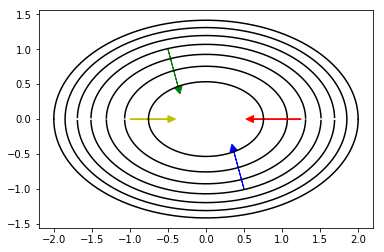

In [48]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# y = +- sqrt(C - (x/2)**2)
def ellipse(x, C = 1):
    val = C - ((x**2)/2)
    if (val >= 0) :
        return np.sqrt(val)
    else:
        return np.nan

    
Cs = np.linspace(0,2,8)
X = np.linspace(-2,2,10000)
def plot_func(f, X, Cs, color = 'black'):
    for C in Cs:
        plt.plot(X ,[f(el, C) for el in X ], color)
        plt.plot(X ,[-f(el, C) for el in X ], color)
        

def plot_grad_at(func, X, color = 'green', lam = 1):
    grad = gradient_f(func, X)
    grad = lam * 0.5 * np.linalg.norm(X)/np.linalg.norm(grad) * grad
    plt.arrow(np.asscalar(X[0]), np.asscalar(X[1]), - np.asscalar(grad[0]), - np.asscalar(grad[1]), head_width=0.1, head_length=0.1, color = color, ec=color)

plot_func(ellipse, X, Cs)

#we take four distinct point as we can observe that the gradient is orthogonal

X1 = np.array([1.25, 0]).reshape(2,1)
X2 = np.array([-0.5, 1]).reshape(2,1)
X3 = np.array([0.5, -1]).reshape(2,1)
X4 = np.array([-1, 0]).reshape(2,1)

plot_grad_at(T, X1, 'red')
plot_grad_at(T, X2, 'green')
plot_grad_at(T, X3,'blue')
plot_grad_at(T, X4,'y')


##### Comments 
We see in this example where ever we take the gradient, is always orthogonal to the level of energy where the point considered belong 

##### 2.2.3 - How constraints looks like ?

Congrat's you haven't gave up yet !!, our objective is still the same, minimize $T(x, y)$ but what is different, is that the gouvernament of our hypothetical world, came up with a law, that you can't approach the origin $(0,0)$ by less than 1 unity of distance.


It is annoying since we know that our minimum is at $(0, 0)$, but it's okih, we are going to deel with this constraint, how this constraint look like ?


This constraint is a circle arround the origin, and our objective now is to figure out, what is the point on the circle that minimize the most $T(x,y)$


In other words we minimize $T(x,y)$ subject to the constraint $R(x,y) = x^2 + y^2 = 1$ or can also be expressed as  $G(x,y) = R(x,y) - 1 = 0$

Let's see how all of that looks like


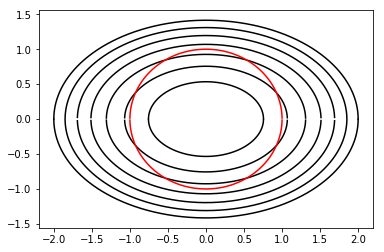

In [51]:
def circle(x, C = 1):
    val = C - ((x**2))
    if (val >= 0) :
        return np.sqrt(val)
    else:
        return np.nan

plot_func(ellipse, X, Cs)
plot_func(circle, X, [1], 'red')


##### Comments
We see intuitively/graphically that the points that satisfy a minimum of $T(x,y)$ and at the same time staying away from the origin by one unity are $(-1,0)$ and $(1,0)$

#### Colinearities of gradients

$R(x,y) = 1$ is a also a level of energy for the function $R(x,y)$ and the gradient computed on any point of this level, will be orthogonal to this level as seen earlier

The idea of a minimization, is to seek for the point where the constraint curve will be tangeant to the minimum energy level that satisfy the constraint

Since both tangant curves are levels of energy, we can infer that their gradient are colinear $\nabla_{x,y} T = \lambda . \nabla_{x,y} R $ 

Since we intuitively found the solution points are $(-1,0)$ and $(1, 0)$, we will plot the gradient in one of them, for both functions and see that the gradients are colinear at this point 

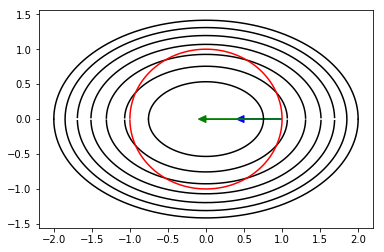

In [52]:
#defining Temprature function
def R(x):
    return ((x[0])**2) + ((x[1])**2) 

plot_func(ellipse, X, Cs)
plot_func(circle, X, [1], 'red')
X1 = np.array([1, 0]).reshape(2,1)
plot_grad_at(T, X1, 'blue')
plot_grad_at(R, X1, 'green', lam = 2)

##### Comments
As we see the gradients of the curves are colinear

##### 2.2.4 - Lagrangian 

We introduce a function called lagrangian such as $L(x,y,\lambda) = T(x,y) + \lambda . R(x,y)$

What happens is that solving $\nabla_{(x,y,\lambda)} L  = 0 \iff \colon\begin{cases}
\nabla_{x,y} T = \lambda . \nabla_{x,y} R\\
R(x,y) = 0
\end{cases}$ 

But there is a problem For us $R(x,y) = 1$ and not $0$ but $G(x,y) = R(x,y) - 1$ is $0$ when $R(x,y) = 1$, so we replace in $L$ $R$ by $G$ such as   $L(x,y,\lambda) = T(x,y) + \lambda . G(x,y)$

Then we obtain solving $\nabla_{(x,y,\lambda)} L  = 0 \iff \colon\begin{cases}
\nabla_{x,y} T = \lambda . \nabla_{x,y} R\\
G(x,y) = 0
\end{cases}$ 

We moved from a problem of optimization with constraint, to another one with greater dimension, without constraint


##### 2.2.5 - multiple constraints

We can have this simplistic reasoning, that each constraint $R_i$ will generate an equation $\nabla_{x,y} T = \lambda_i . \nabla_{x,y} R_i\\$

If we have $m$ constraints we obtain m equations that we can some together : $ m \nabla_{x,y} T = \sum_{i = 1}^{i = m} \lambda_i . \nabla_{x,y} R_i$ 

by considering $\lambda_i \leftarrow \frac{\lambda_i}{m}$

We end up with a lagrangian expressed as $L(x,y,\lambda_1,..,\lambda_i,.., \lambda_m) = T(x,y) + \lambda . G(x,y)$

where $\lambda^T = (\lambda_1,..,\lambda_i, ..,\lambda_m)$ and $G(x,y)^T = (g_1(x,y),..,g_i(x,y),..,g_m(x,y))$  is a function from ${\Bbb R}^2\longrightarrow {\Bbb R}^m $

For more precise and rigorous (but difficult) informations, please check those links [link1](https://en.wikipedia.org/wiki/Lagrange_multiplier), [link2](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions)


##### 2.2.6 - implementation

In [53]:
def lagrangien(func, N, phis = []):
    return lambda x: np.asscalar(func(x[:N]) + x[N:].T.dot(np.array([phi(x[:N]) for phi in phis])).reshape(len(x[N:]),1))